In [49]:
sessionInfo()

R version 4.0.4 (2021-02-15)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.1 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.9.0
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.9.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ggplot2_3.4.3

loaded via a namespace (and not attached):
 [1] pillar_1.9.0     compiler_4.0.4   base64enc_0.1-3  tools_4.0.4     
 [5] digest_0.6.33    uuid_0.1-4       jsonlite_1.8.4   evaluate_0.20   
 [9] lifecycle_1.0.3  tibble_3.2.1     gtable_0.3.4     pkgc

In [ ]:
# 1. ran this part on openstack instance -------------------------------------
BiocManager::install("GenomicAlignments")
library(GenomicAlignments)
meta <- read.csv(file = 'meta_ALI.csv', header = T, row.names=1, sep="\t", as.is=T)
samples <- read.csv(file = 'samples.txt', header = T, sep=',', as.is=T)

for (SAMPLE in unique(samples$sample_id)) {
  cat(SAMPLE)
    if (!file.exists(paste0("/mnt/ALI_SARS/viral_abundance/data/viralReads/",SAMPLE,".viralReads.txt"))) {
     system(paste0("iget /archive/HCA/10X/",SAMPLE,"/starsolo/Aligned.sortedByCoord.out.bam /mnt/ALI_SARS/viral_abundance"))
      system("samtools index -@ 15 /mnt/ALI_SARS/viral_abundance/Aligned.sortedByCoord.out.bam")
      system("samtools view -b /mnt/ALI_SARS/viral_abundance/Aligned.sortedByCoord.out.bam NC_045512.2 > /mnt/ALI_SARS/viral_abundance/viralOnly.bam")
      system("java -jar /mnt/ALI_SARS/viral_abundance/picard.jar MarkDuplicates INPUT=/mnt/ALI_SARS/viral_abundance/viralOnly.bam OUTPUT= /mnt/ALI_SARS/viral_abundance/viralOnly.rmdup.bam REMOVE_DUPLICATES=true ASSUME_SORTED=true METRICS_FILE=/mnt/ALI_SARS/viral_abundance/temp.txt")
      system("samtools index -@ 15 /mnt/ALI_SARS/viral_abundance/viralOnly.rmdup.bam")
      myBam <- readGAlignments("/mnt/ALI_SARS/viral_abundance/viralOnly.rmdup.bam", param=ScanBamParam(tag=c("CB"), what="flag"))
      myBamDf <- as.data.frame(myBam)
      write.table(myBamDf,file = paste0("/mnt/ALI_SARS/viral_abundance/data/viralReads/",SAMPLE,".viralReads.txt"),sep = "\t",quote = F,col.names = T,row.names = F)
      file.remove(c("/mnt/ALI_SARS/viral_abundance/Aligned.sortedByCoord.out.bam","/mnt/ALI_SARS/viral_abundance/Aligned.sortedByCoord.out.bam.bai", "/mnt/ALI_SARS/viral_abundance/viralOnly.bam", "/mnt/ALI_SARS/viral_abundance/viralOnly.rmdup.bam.bai", "/mnt/ALI_SARS/viral_abundance/viralOnly.rmdup.bam","/mnt/ALI_SARS/viral_abundance/temp.txt"))
      cat("\n\n")
  }
}

for (SAMPLE in unique(samples$sample_id)) {
  tempReads <- read.csv(paste0("/mnt/ALI_SARS/viral_abundance/data/viralReads/",SAMPLE,".viralReads.txt"),header = T,stringsAsFactors = F,sep = "\t")
  tempReads <- tempReads[!is.na(tempReads$CB),]
  tempReads$barcode <- paste0(SAMPLE,"_",tempReads$CB)
  if (exists("viralReads")) {
    viralReads <- rbind(viralReads,tempReads)
  } else { viralReads <- tempReads }
}

myViral <- viralReads[viralReads$barcode%in%rownames(meta_ALI),]

In [50]:
library ('ggplot2')

In [9]:
# 2. ran this part after output from openstack to plot data -------------------------------
viral_reads <- read.csv(file = '/nfs/team205/ac65/ALI_COVID19/ALI_SARS_GPLVM/viralReads/final_viralReads.txt', header = T, sep=',', as.is=T)
head(viral_reads)

,seqnames,strand,cigar,qwidth,start,end,width,njunc,flag,CB,barcode
,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>
1,NC_045512.2,-,90M,90,1635,1724,90,0,16,CTGCGGACATTAGGCT,CV001_KM10202573_CTGCGGACATTAGGCT
2,NC_045512.2,-,90M,90,27058,27147,90,0,16,ACGGGCTGTCGACTAT,CV001_KM10202574_ACGGGCTGTCGACTAT
3,NC_045512.2,-,85M5S,90,10118,10202,85,0,16,CATGACACACAGGCCT,CV001_KM10202575_CATGACACACAGGCCT
4,NC_045512.2,-,90M,90,26748,26837,90,0,16,GCATGTATCTCAACTT,CV001_KM10202577_GCATGTATCTCAACTT
5,NC_045512.2,-,90M,90,29714,29803,90,0,16,ACCAGTACAACGCACC,CV001_KM10202578_ACCAGTACAACGCACC
6,NC_045512.2,-,90M,90,27119,27208,90,0,16,CTCGAGGCATTAACCG,CV001_KM10202579_CTCGAGGCATTAACCG


In [14]:
meta_ALI <- read.csv(file = '/home/jovyan/3_ALI-SARS/GLMM/adata_fig_2_metadata_glmm.csv')
head(meta_ALI)

,X,sample,treatment,time,pool,sample_name,kit_version,spike.in_primer,batch,scrublet_leiden,⋯,ziegler_predicted_labels,ziegler_over_clustering,ziegler_majority_voting,ziegler_conf_score,score_HILLOCK,viral_gene,age_treatment,cell_viral_gene,age_treatment_time,age_treatment_time_mock_together
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,⋯,<chr>,<int>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
1,CV001_KM10202575_AAACCTGAGCAGGTCA,CV001_KM10202575,mock,4h,ALI2,ALI2_mock_4h_v1.1,v1.1,spike-in_LOW,2,"2,12",⋯,SERPINB11 high Secretory Cells,287,SERPINB11 high Secretory Cells,1.000000e+00,0.67103380,False,Adult-mock,not-infected,Adult-mock-4h,Adult-mock
2,CV001_KM10202575_AAACCTGAGCCAGTTT,CV001_KM10202575,mock,4h,ALI2,ALI2_mock_4h_v1.1,v1.1,spike-in_LOW,2,"2,37",⋯,SERPINB11 high Secretory Cells,206,SERPINB11 high Secretory Cells,1.000000e+00,0.44731568,False,Adult-mock,not-infected,Adult-mock-4h,Adult-mock
3,CV001_KM10202575_AAACCTGAGCGTAGTG,CV001_KM10202575,mock,4h,ALI2,ALI2_mock_4h_v1.1,v1.1,spike-in_LOW,2,"3,41",⋯,BPIFA1 high Secretory Cells,267,SERPINB11 high Secretory Cells,4.260299e-35,0.38131628,False,Adult-mock,not-infected,Adult-mock-4h,Adult-mock
4,CV001_KM10202575_AAACCTGAGCTCCTTC,CV001_KM10202575,mock,4h,ALI2,ALI2_mock_4h_v1.1,v1.1,spike-in_LOW,2,"5,22",⋯,SERPINB11 high Secretory Cells,16,SERPINB11 high Secretory Cells,1.000000e+00,1.35709733,False,Elderly-mock,not-infected,Elderly-mock-4h,Elderly-mock
5,CV001_KM10202575_AAACCTGAGCTGGAAC,CV001_KM10202575,mock,4h,ALI2,ALI2_mock_4h_v1.1,v1.1,spike-in_LOW,2,"6,0",⋯,SERPINB11 high Secretory Cells,57,Basal Cells,1.000000e+00,1.77055308,False,Elderly-mock,not-infected,Elderly-mock-4h,Elderly-mock
6,CV001_KM10202575_AAACCTGAGGGATGGG,CV001_KM10202575,mock,4h,ALI2,ALI2_mock_4h_v1.1,v1.1,spike-in_LOW,2,"2,9",⋯,SERPINB11 high Secretory Cells,217,AZGP1 high Goblet Cells,1.000000e+00,-0.02877484,False,Elderly-mock,not-infected,Elderly-mock-4h,Elderly-mock


In [16]:
meta_ALI$barcode <- meta_ALI$X
viral_meta <- merge(viral_reads,meta_ALI,by="barcode")
viral_meta_paed <- subset(viral_meta, viral_meta$age_group == 'Paediatric')
viral_meta_adult <- subset(viral_meta, viral_meta$age_group == 'Adult')
viral_meta_elderly <- subset(viral_meta, viral_meta$age_group == 'Elderly')

In [24]:
viral_meta_paed_no_primer <- subset(viral_meta_paed, viral_meta_paed$spike.in_primer == 'NONE')
viral_meta_adult_no_primer <- subset(viral_meta_adult, viral_meta_adult$spike.in_primer == 'NONE')
viral_meta_elderly_no_primer  <- subset(viral_meta_elderly, viral_meta_elderly$spike.in_primer == 'NONE')
viral_meta_no_primer <- subset(viral_meta, viral_meta$spike.in_primer == 'NONE')
viral_meta_only_primer <- subset(viral_meta, viral_meta$spike.in_primer == 'spike-in_LOW')

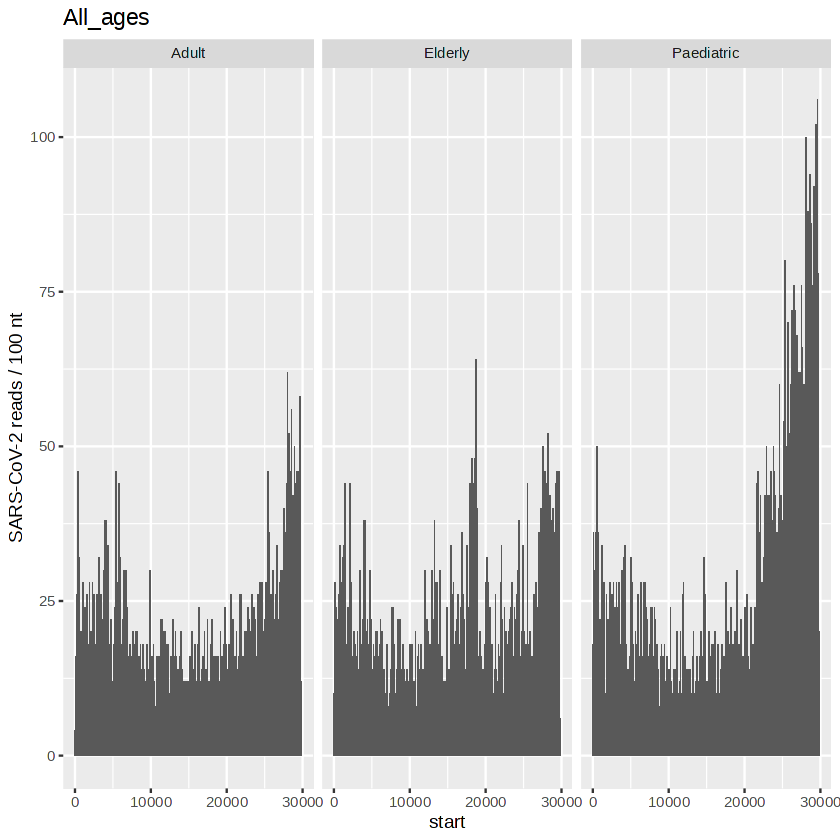

In [60]:
ggplot(viral_meta_only_primer, aes(start)) + 
  geom_histogram(bins = round(max(viral_meta_no_primer$start) / 100)) +
  facet_wrap(~ annotation_v5) + 
  ylab("SARS-CoV-2 reads / 100 nt") + 
  ggtitle("All_ages") + 
  facet_grid(~ age_group)

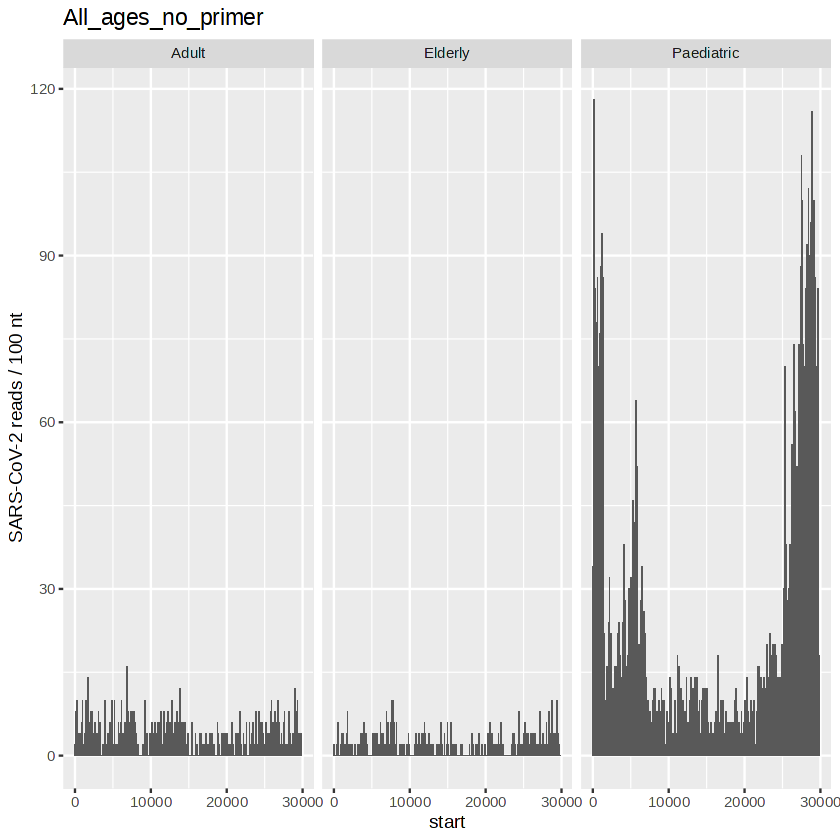

In [59]:
ggplot(viral_meta_no_primer, aes(start)) + 
  geom_histogram(bins = round(max(viral_meta_no_primer$start) / 100)) +
  facet_wrap(~ annotation_v5) + 
  ylab("SARS-CoV-2 reads / 100 nt") + 
  ggtitle("All_ages_no_primer") + 
  facet_grid(~ age_group)

[1] 15300

[1] 7008

[1] 6860

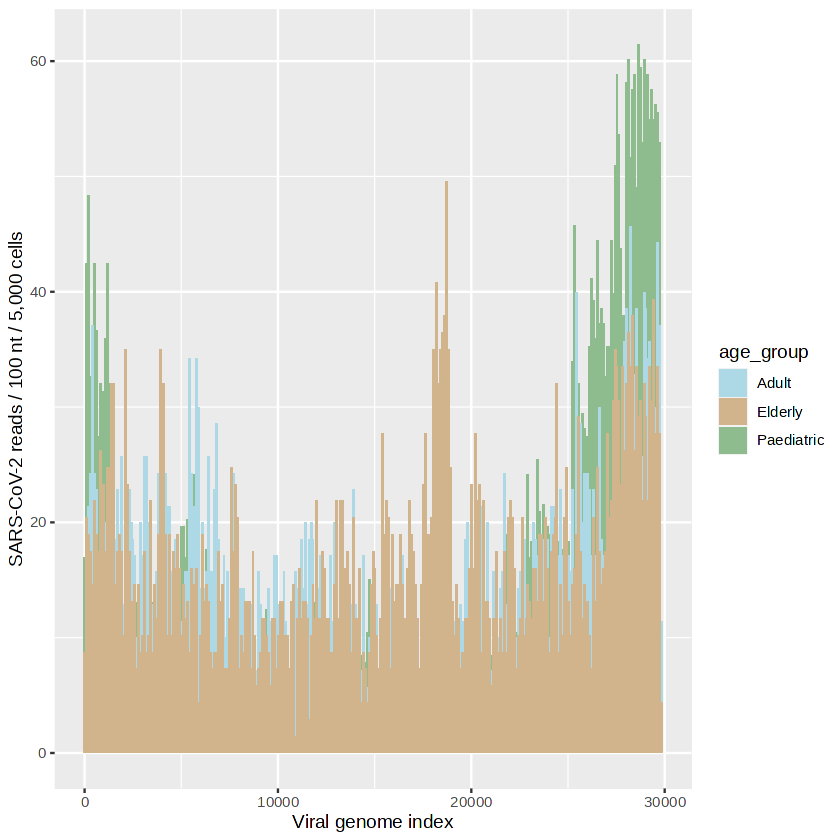

In [29]:
# normalize viral counts per cell number ----------------------------------
#count total rows in data frame with Paediatric/Adult/Elderly category in 'age_group' column
nrow(viral_meta[viral_meta$age_group == 'Paediatric',])
nrow(viral_meta[viral_meta$age_group == 'Adult',])
nrow(viral_meta[viral_meta$age_group == 'Elderly',])

#https://stackoverflow.com/questions/48922858/r-ggplot2-histogram-overlays-with-normalized-values-for-each-histogram

viral_meta$age_group <- factor(viral_meta$age_group, levels = c('Paediatric', 'Adult', 'Elderly'))

ggplot(viral_meta,aes(x=start, group=age_group, fill=age_group)) + 
  geom_histogram(data=subset(viral_meta, age_group == 'Paediatric'),
                 aes(y=(..count../sum(..count..))*5000), bins = round(max(29903)/100)) + 
  geom_histogram(data=subset(viral_meta, age_group == 'Adult'),
                 aes(y=(..count../sum(..count..))*5000), bins = round(max(29903)/100)) +
  geom_histogram(data=subset(viral_meta, age_group == 'Elderly'),
                 aes(y=(..count../sum(..count..))*5000), bins = round(max(29903)/100)) +
  scale_fill_manual(values = c('lightblue', 'tan', 'darkseagreen')) +
  ylab("SARS-CoV-2 reads / 100 nt / 5,000 cells") + xlab("Viral genome index")

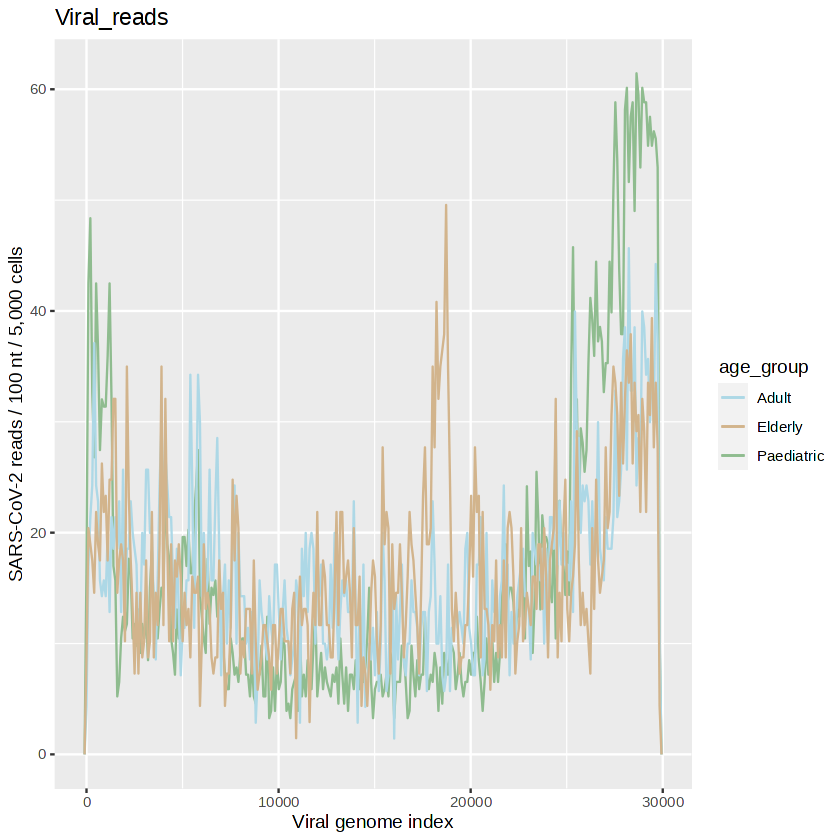

In [56]:
ggplot(viral_meta_72h,aes(x=start, group=age_group, colour=age_group)) + 
  geom_freqpoly(data=subset(viral_meta, age_group == 'Paediatric'),
                aes(y=(..count../sum(..count..))*5000), bins = round(max(29903)/100)) + 
  geom_freqpoly(data=subset(viral_meta, age_group == 'Adult'),
                aes(y=(..count../sum(..count..))*5000), bins = round(max(29903)/100)) +
  geom_freqpoly(data=subset(viral_meta, age_group == 'Elderly'),
                aes(y=(..count../sum(..count..))*5000), bins = round(max(29903)/100)) +
  scale_color_manual(values = c('lightblue', 'tan', 'darkseagreen')) +
  ylab("SARS-CoV-2 reads / 100 nt / 5,000 cells") + xlab("Viral genome index")+ ggtitle("Viral_reads")

In [30]:
#show viral reads per age per timepoint ----------------------------------
viral_meta_4h <- subset(viral_meta, viral_meta$time == '4h')
viral_meta_24h <- subset(viral_meta, viral_meta$time == '24h')
viral_meta_72h <- subset(viral_meta, viral_meta$time == '72h')

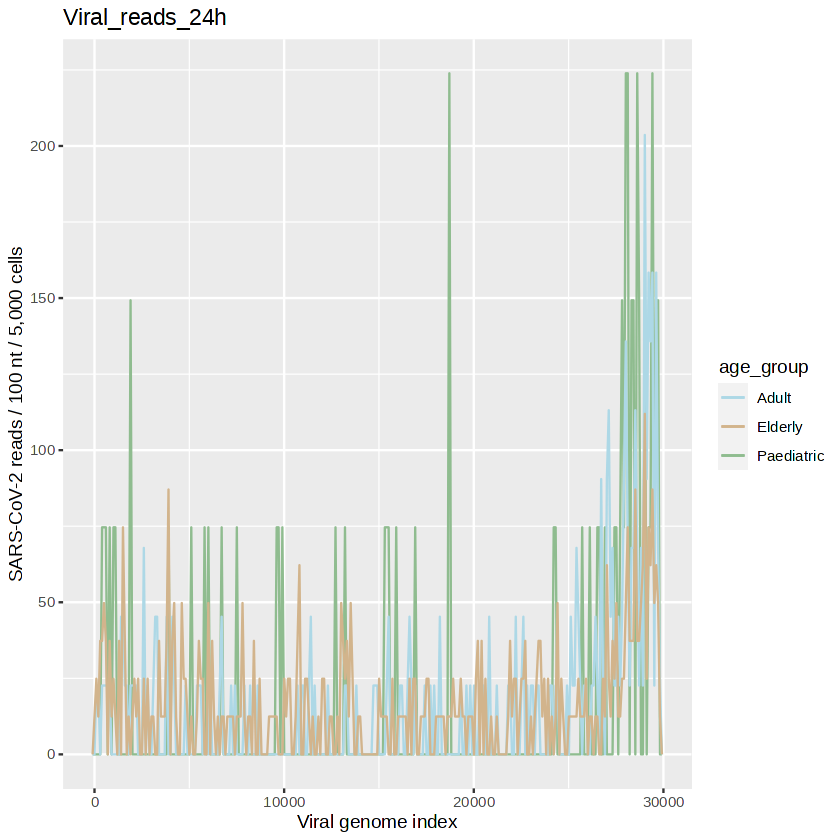

In [31]:
ggplot(viral_meta_24h,aes(x=start, group=age_group, colour=age_group)) + 
  geom_freqpoly(data=subset(viral_meta_24h, age_group == 'Paediatric'),
                 aes(y=(..count../sum(..count..))*5000), bins = round(max(29903)/100)) + 
  geom_freqpoly(data=subset(viral_meta_24h, age_group == 'Adult'),
                 aes(y=(..count../sum(..count..))*5000), bins = round(max(29903)/100)) +
  geom_freqpoly(data=subset(viral_meta_24h, age_group == 'Elderly'),
                 aes(y=(..count../sum(..count..))*5000), bins = round(max(29903)/100)) +
  scale_color_manual(values = c('lightblue', 'tan', 'darkseagreen')) +
  ylab("SARS-CoV-2 reads / 100 nt / 5,000 cells") + xlab("Viral genome index")+ ggtitle("Viral_reads_24h")

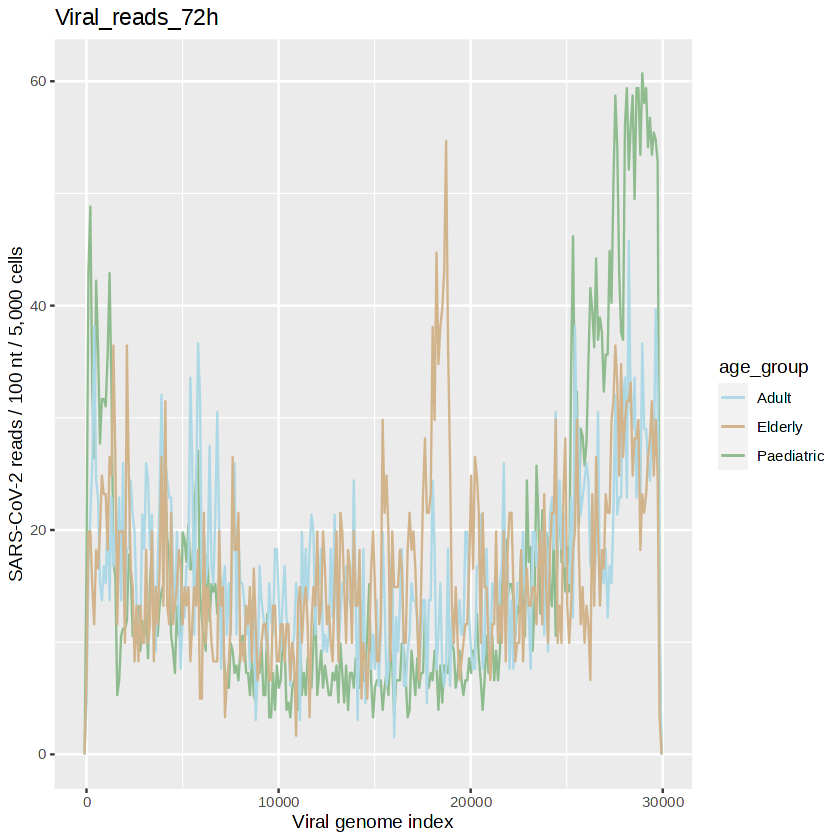

In [32]:
ggplot(viral_meta_72h,aes(x=start, group=age_group, colour=age_group)) + 
  geom_freqpoly(data=subset(viral_meta_72h, age_group == 'Paediatric'),
                aes(y=(..count../sum(..count..))*5000), bins = round(max(29903)/100)) + 
  geom_freqpoly(data=subset(viral_meta_72h, age_group == 'Adult'),
                aes(y=(..count../sum(..count..))*5000), bins = round(max(29903)/100)) +
  geom_freqpoly(data=subset(viral_meta_72h, age_group == 'Elderly'),
                aes(y=(..count../sum(..count..))*5000), bins = round(max(29903)/100)) +
  scale_color_manual(values = c('lightblue', 'tan', 'darkseagreen')) +
  ylab("SARS-CoV-2 reads / 100 nt / 5,000 cells") + xlab("Viral genome index")+ ggtitle("Viral_reads_72h")

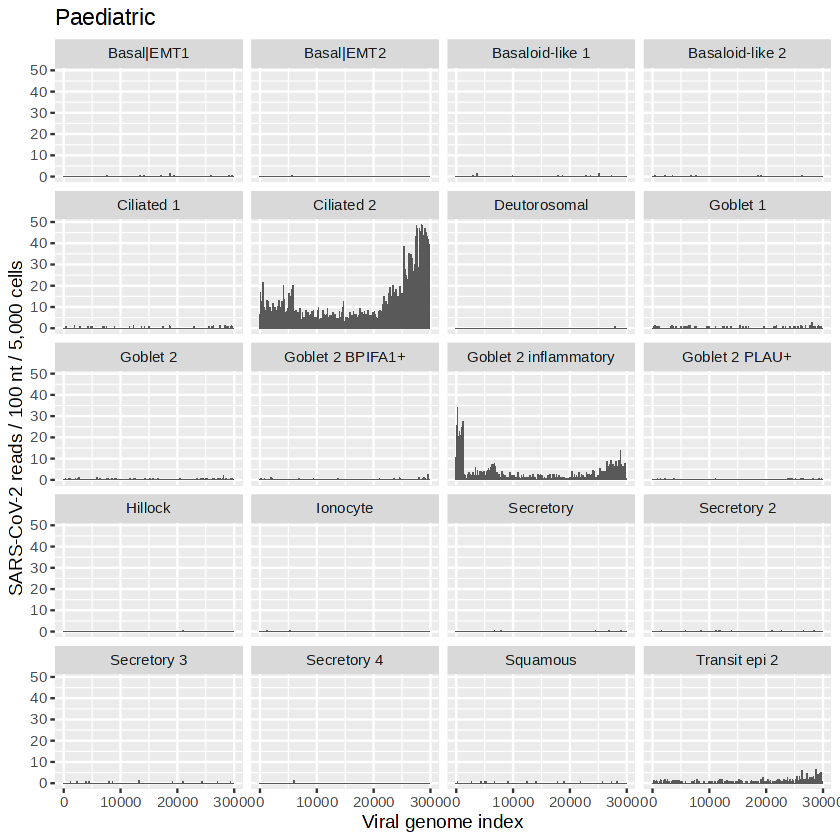

In [36]:
ggplot(viral_meta_paed,aes(start)) + geom_histogram(aes(y=(..count../sum(..count..))*5000),bins = round(max(29903)/100)) + 
  facet_wrap(~annotation_v5, ncol = 4) + ylab("SARS-CoV-2 reads / 100 nt / 5,000 cells") + 
  ggtitle("Paediatric") + xlab("Viral genome index")


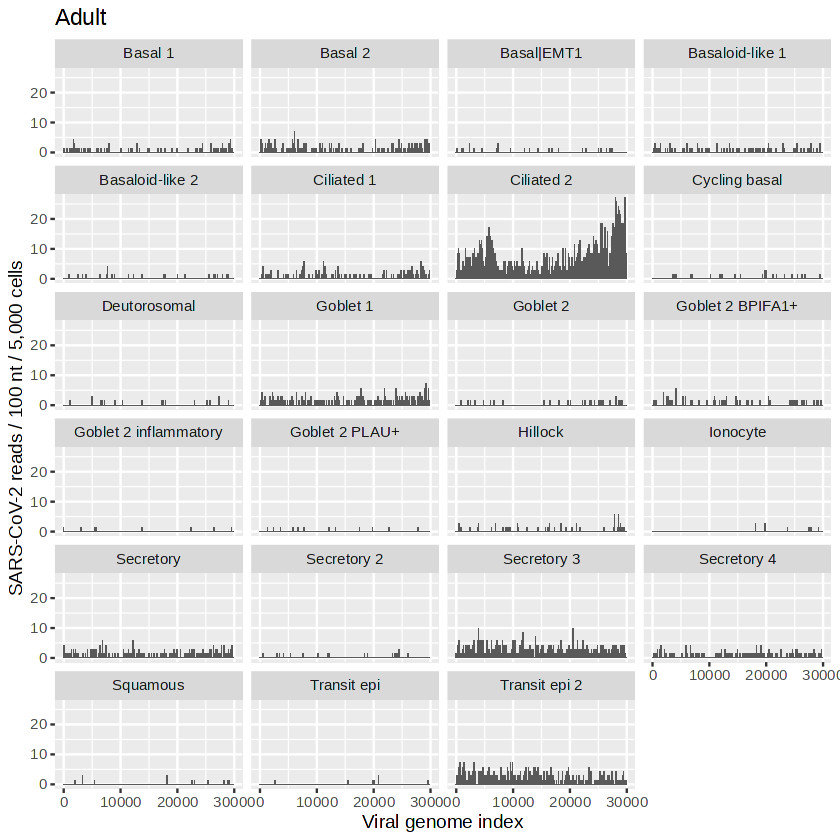

In [37]:
ggplot(viral_meta_adult,aes(start)) + geom_histogram(aes(y=(..count../sum(..count..))*5000),bins = round(max(29903)/100)) + 
  facet_wrap(~annotation_v5, ncol = 4) + ylab("SARS-CoV-2 reads / 100 nt / 5,000 cells") + 
  ggtitle("Adult") + xlab("Viral genome index")

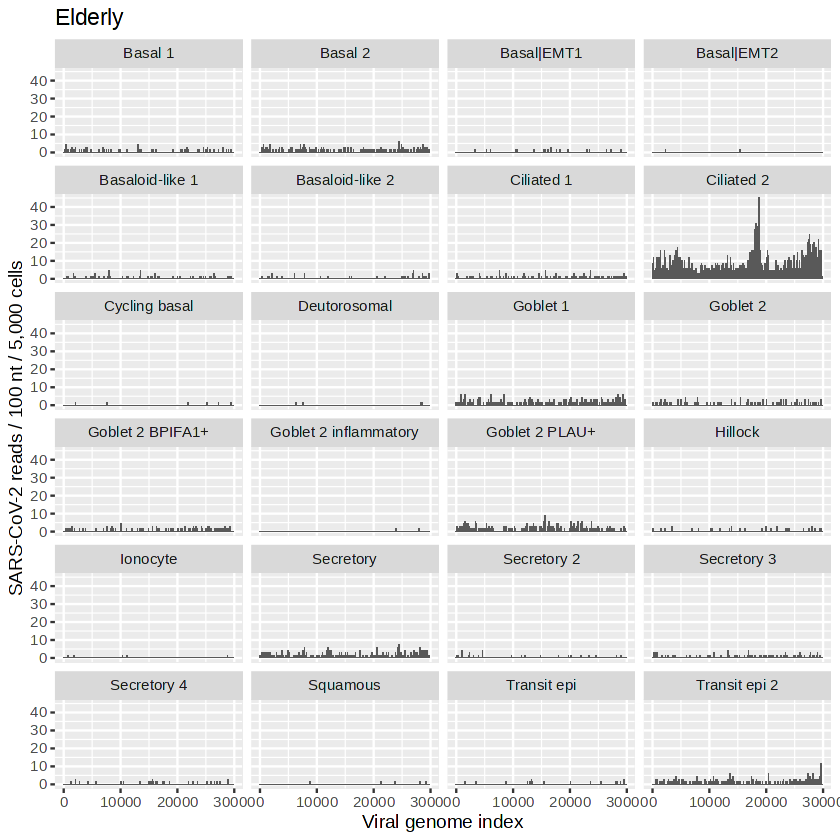

In [38]:
ggplot(viral_meta_elderly,aes(start)) + geom_histogram(aes(y=(..count../sum(..count..))*5000),bins = round(max(29903)/100)) + 
  facet_wrap(~annotation_v5, ncol = 4) + ylab("SARS-CoV-2 reads / 100 nt / 5,000 cells") + 
  ggtitle("Elderly") + xlab("Viral genome index")

In [61]:
# to show goblet over time in paed only---------------------------------- 
viral_meta_goblet <- subset(viral_meta_paed, viral_meta_paed$annotation_v5 == 'Goblet 2 inflammatory')
viral_meta_goblet_mock <- subset(viral_meta_goblet, viral_meta_goblet$treatment == 'mock')
viral_meta_goblet_4h <- subset(viral_meta_goblet, viral_meta_goblet$time == '4h')
viral_meta_goblet_24h <- subset(viral_meta_goblet, viral_meta_goblet$time == '24h')
viral_meta_goblet_72h <- subset(viral_meta_goblet, viral_meta_goblet$time == '72h')

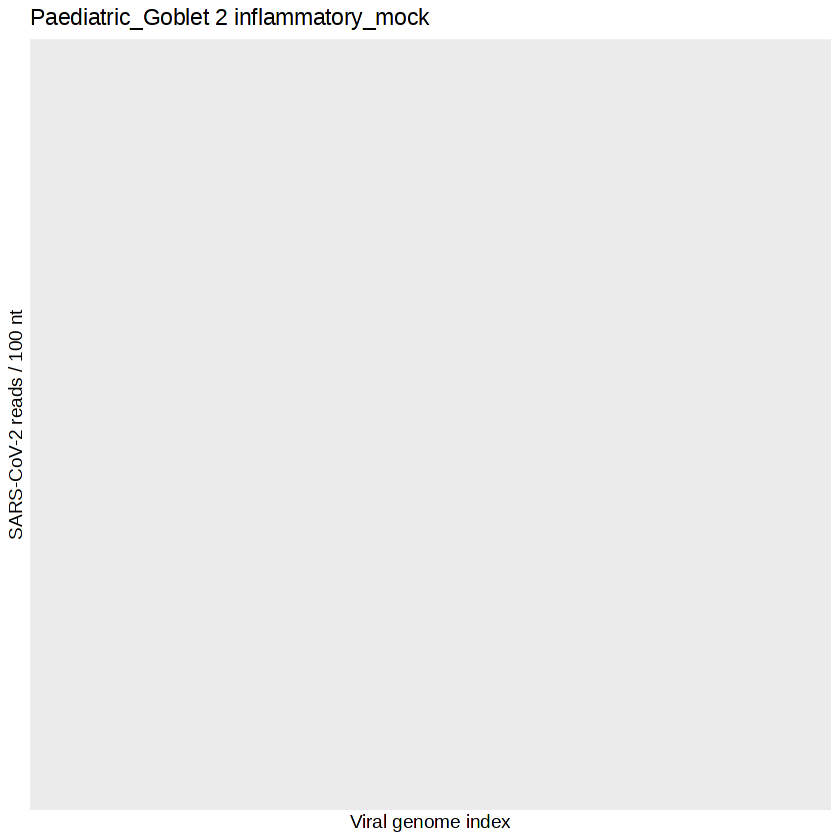

In [62]:
ggplot(viral_meta_goblet_mock,aes(start)) +geom_histogram(bins = round(max(29903)/100)) + 
ylab("SARS-CoV-2 reads / 100 nt") + 
ggtitle("Paediatric_Goblet 2 inflammatory_mock") + xlab("Viral genome index")

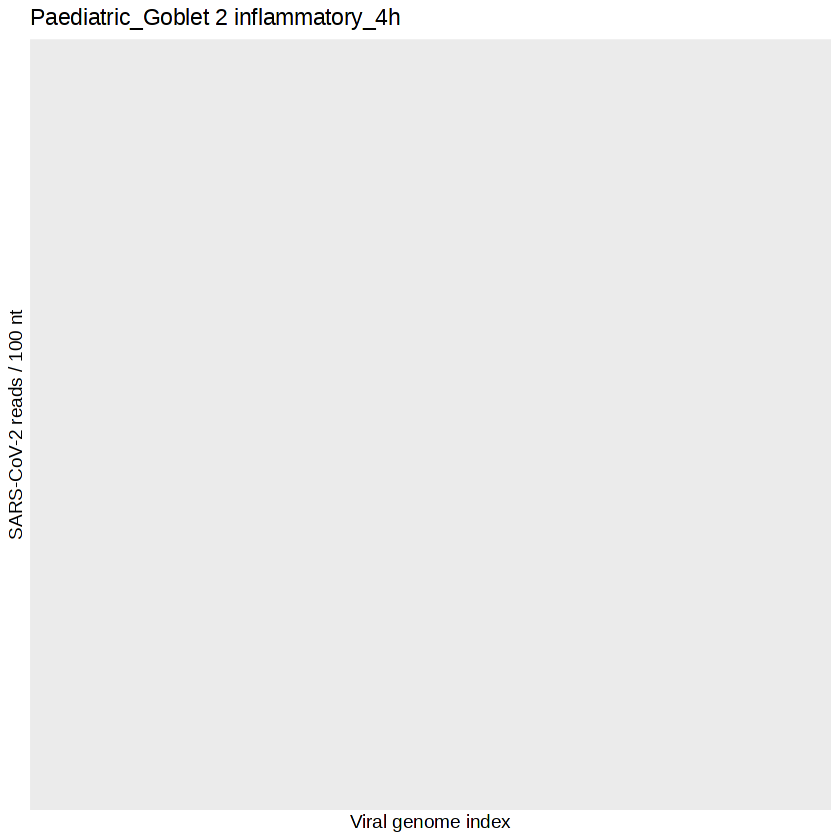

In [41]:
ggplot(viral_meta_goblet_4h,aes(start)) + geom_histogram(bins = round(max(29903)/100)) + 
ylab("SARS-CoV-2 reads / 100 nt") + 
ggtitle("Paediatric_Goblet 2 inflammatory_4h") + xlab("Viral genome index")

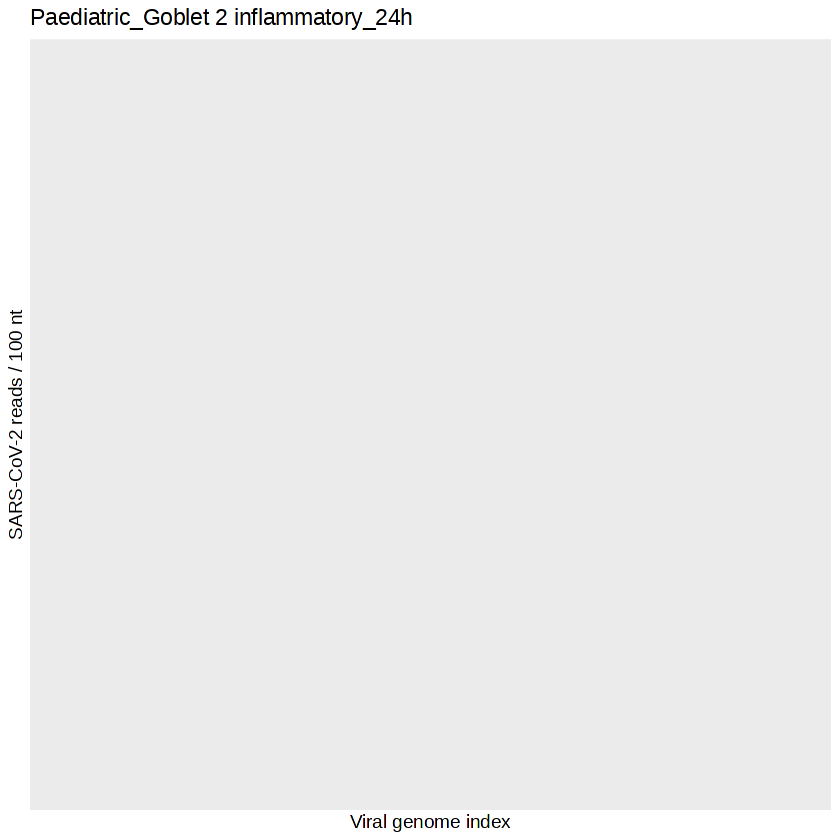

In [42]:
ggplot(viral_meta_goblet_24h,aes(start)) + geom_histogram(bins = round(max(29903)/100)) + 
ylab("SARS-CoV-2 reads / 100 nt") + 
ggtitle("Paediatric_Goblet 2 inflammatory_24h") + xlab("Viral genome index")

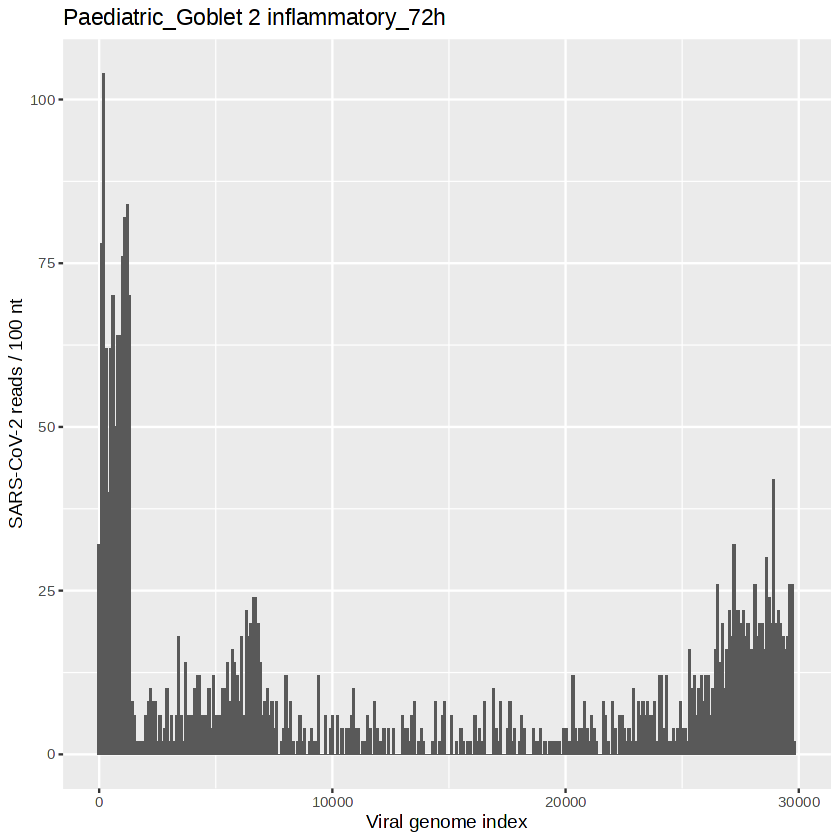

In [43]:
ggplot(viral_meta_goblet_72h,aes(start)) + geom_histogram(bins = round(max(29903)/100)) + 
ylab("SARS-CoV-2 reads / 100 nt") + 
ggtitle("Paediatric_Goblet 2 inflammatory_72h") + xlab("Viral genome index")

In [44]:
# to show ciliated 2 over time ---------------------------------- 
viral_meta_ciliated <- subset(viral_meta_paed, viral_meta_paed$annotation_v5 == 'Ciliated 2')
viral_meta_ciliated_mock <- subset(viral_meta_ciliated, viral_meta_ciliated$treatment == 'mock')
viral_meta_ciliated_4h <- subset(viral_meta_ciliated, viral_meta_ciliated$time == '4h')
viral_meta_ciliated_24h <- subset(viral_meta_ciliated, viral_meta_ciliated$time == '24h')
viral_meta_ciliated_72h <- subset(viral_meta_ciliated, viral_meta_ciliated$time == '72h')

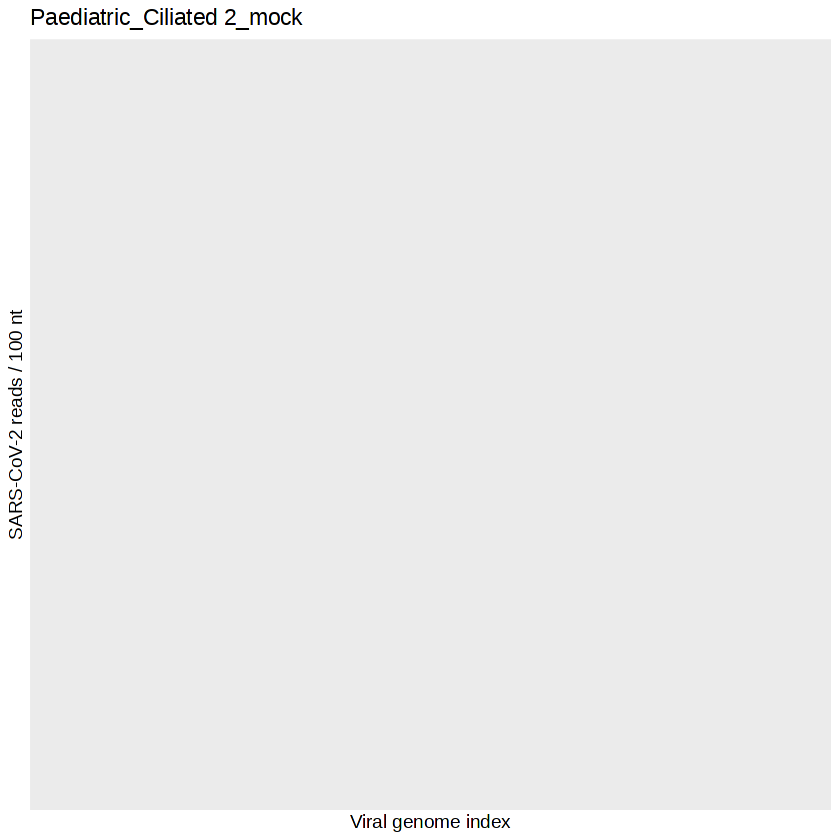

In [45]:
ggplot(viral_meta_ciliated_mock,aes(start)) +geom_histogram(bins = round(max(29903)/100)) + 
  ylab("SARS-CoV-2 reads / 100 nt") + 
  ggtitle("Paediatric_Ciliated 2_mock") + xlab("Viral genome index")

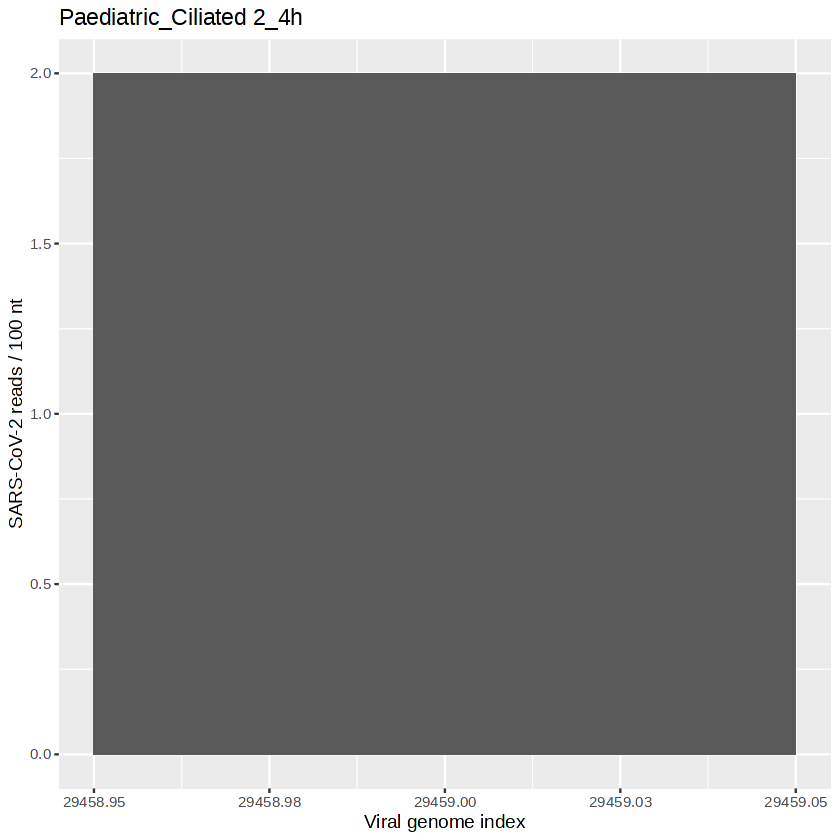

In [46]:
ggplot(viral_meta_ciliated_4h,aes(start)) + geom_histogram(bins = round(max(29903)/100)) + 
  ylab("SARS-CoV-2 reads / 100 nt") + 
  ggtitle("Paediatric_Ciliated 2_4h") + xlab("Viral genome index")

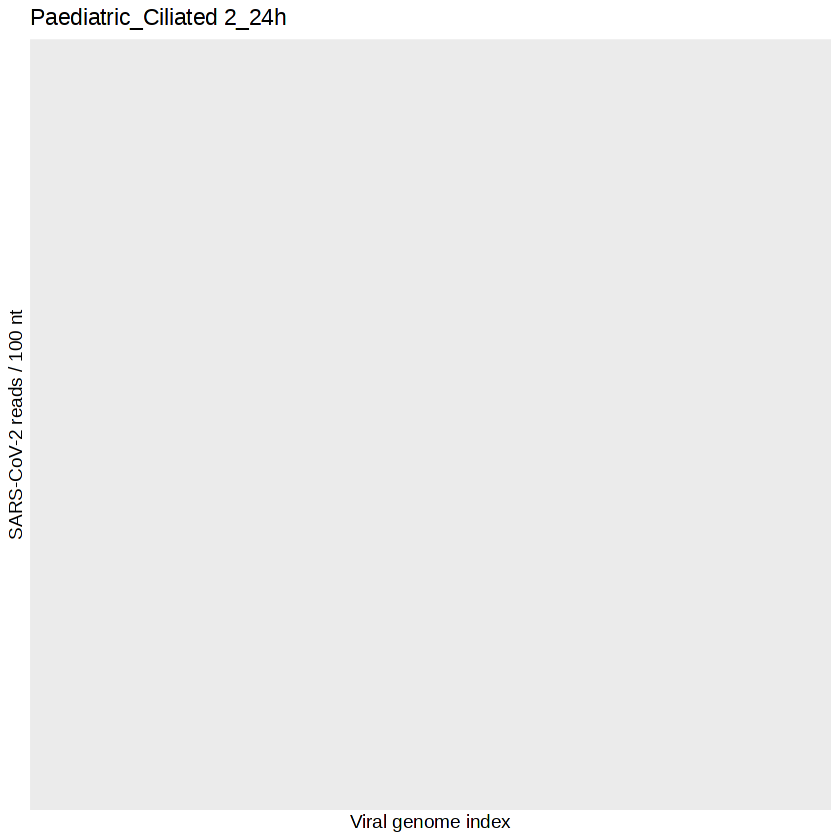

In [47]:
ggplot(viral_meta_ciliated_24h,aes(start)) + geom_histogram(bins = round(max(29903)/100)) + 
  ylab("SARS-CoV-2 reads / 100 nt") + 
  ggtitle("Paediatric_Ciliated 2_24h") + xlab("Viral genome index")

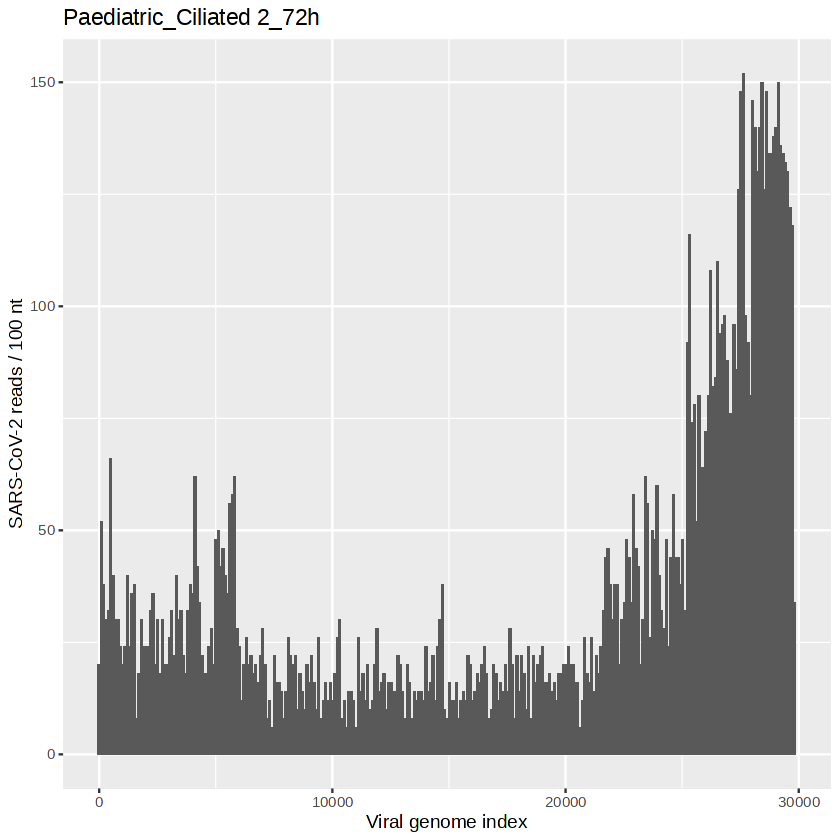

In [48]:
ggplot(viral_meta_ciliated_72h,aes(start)) + geom_histogram(bins = round(max(29903)/100)) + 
  ylab("SARS-CoV-2 reads / 100 nt") + 
  ggtitle("Paediatric_Ciliated 2_72h") + xlab("Viral genome index")